I provide two ways of modeling seasonal effect. For effects that take less values (e.g. weekly effects), we can assign a state value to each day. For effects that have a longer cycle (e.g. quarterly effects), we may model them using trigonmetric cycles.


In [1]:
"""
Fixed effect model
"""
import numpy as np
import pandas as pd
import linkalman
import scipy
from linkalman.models import BaseConstantModel as BCM
from linkalman.core.utils import Constant_M
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline 



/usr/local/Cellar/python/3.7.2_2/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


# Initialization

Here we only talk about weekly effects. The state $\xi_t$ is a 7-by-1 vector.

In [2]:
def my_f(theta):
    # Generate F
    sigQ = np.exp(theta[0])
    sigR = np.exp(theta[1])
    F = np.array([[-1, -1, -1, -1, -1, -1], 
                 [1, 0, 0, 0, 0, 0], 
                 [0, 1, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0],
                 [0, 0, 0, 0, 1, 0]])
    # Generate Q
    Q = np.zeros([6, 6])
    Q[0, 0] = sigQ
    R = np.array([[sigR]])
    # Generate H
    H = np.array([[1, 0, 0, 0, 0, 0]])
    # Collect system matrices
    M = {'F': F, 'Q': Q, 'H': H, 'R': R}

    return M


In [3]:
def my_solver(param, obj_func, verbose=False, **kwargs):
    """
    Simple solver for LLY
    """
    obj_ = lambda x: -obj_func(x)
    def disp_f(x):
        print('theta is {}. Function value is: {}.'.format(x, obj_func(x)))
    callbackf = None
    if verbose:
        callbackf = disp_f
    res = minimize(obj_, param, callback=callbackf, **kwargs)
    theta_opt = np.array(res.x)
    fval_opt = res.fun
    return theta_opt, fval_opt

In [4]:
# Initialize the model
x = 1  
model = BCM()
model.set_f(my_f, is_warning=False)
model.set_solver(my_solver, method='nelder-mead', 
        options={'xatol': 1e-7, 'disp': True, 'maxiter': 10000}, verbose=True) 

# Generate Synthetic Data

In [5]:
# Some initial parameters
theta = np.array([1, -0.1, 0.2, -3])  
T = 180
train_split_ratio = 0.7
forecast_cutoff_ratio = 0.8  
missing_range = [0.3, 0.4]

# Split train data
train_split_t = np.floor(T * train_split_ratio).astype(int)

# Generate missing data for forcasting
forecast_t = np.floor(T * forecast_cutoff_ratio).astype(int)

x_col = ['const']
Xt = pd.DataFrame({x_col[0]: x * np.ones(T)})  

# Build simulated data
df, y_col, xi_col = model.simulated_data(input_theta=theta, Xt=Xt)

# Store fully visible y for comparison later
df['y_0_vis'] = df.y_0.copy()  

# Insert some missingness
missing_start_t = np.floor(T * missing_range[0]).astype(int)
missing_end_t = np.floor(T * missing_range[1]).astype(int)
is_missing = (df.index >= missing_start_t) & (df.index < missing_end_t)
df.loc[is_missing, ['y_0']] = np.nan

# Splits models into three groups
is_train = df.index < train_split_t
is_test = (~is_train) & (df.index < forecast_t)
is_forecast = ~(is_train | is_test)

# Create a training and test data
df_train = df.loc[is_train].copy()

# Build two kinds of test data (full data vs. test data only)
df_test = df.copy()  
df_test_only = df.loc[is_test | is_forecast].copy()  

# Create an offset
df_test.loc[is_forecast, ['y_0']] = np.nan
df_test_only.loc[df_test_only.index >= forecast_t, ['y_0']] = np.nan

# Fit and Predict

In [6]:
# Fit data using LLY:
theta_init = np.random.rand(len(theta))
model.fit(df_train, theta_init, y_col=y_col, x_col=x_col, 
              method='LLY')

# Make predictions from LLY:
df_LLY = model.predict(df_test)
df_LLY['kf_ub'] = df_LLY.y_0_filtered + 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['kf_lb'] = df_LLY.y_0_filtered - 1.96 * np.sqrt(df_LLY.y_0_fvar)
df_LLY['ks_ub'] = df_LLY.y_0_smoothed + 1.96 * np.sqrt(df_LLY.y_0_svar)
df_LLY['ks_lb'] = df_LLY.y_0_smoothed - 1.96 * np.sqrt(df_LLY.y_0_svar)

# Make predictions using true theta:
df_true = model.predict(df_test, theta=theta)
df_true['kf_ub'] = df_true.y_0_filtered + 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['kf_lb'] = df_true.y_0_filtered - 1.96 * np.sqrt(df_true.y_0_fvar)
df_true['ks_ub'] = df_true.y_0_smoothed + 1.96 * np.sqrt(df_true.y_0_svar)
df_true['ks_lb'] = df_true.y_0_smoothed - 1.96 * np.sqrt(df_true.y_0_svar)

theta is [0.84857806 0.53179909 0.4480276  0.52561826]. Function value is: -246.56211086632143.
theta is [0.84857806 0.53179909 0.4480276  0.52561826]. Function value is: -246.56211086632143.
theta is [0.83679225 0.51498014 0.47434247 0.48683016]. Function value is: -246.1395454785418.
theta is [0.75723806 0.51678217 0.4468468  0.52264978]. Function value is: -245.38534003744476.
theta is [0.61801822 0.51993573 0.50128992 0.53467211]. Function value is: -244.66675228858904.
theta is [0.61801822 0.51993573 0.50128992 0.53467211]. Function value is: -244.66675228858904.
theta is [0.57474221 0.51664452 0.50547542 0.49950803]. Function value is: -244.5384135857701.
theta is [0.57474221 0.51664452 0.50547542 0.49950803]. Function value is: -244.5384135857701.
theta is [0.57474221 0.51664452 0.50547542 0.49950803]. Function value is: -244.5384135857701.
theta is [0.46499552 0.47995299 0.51082244 0.56336487]. Function value is: -244.19612692396234.
theta is [0.46499552 0.47995299 0.51082244 0

theta is [ 0.69672117 -0.09675923  0.82685849  0.31039073]. Function value is: -240.04614691248256.
theta is [ 0.69672726 -0.09676168  0.82688577  0.31031667]. Function value is: -240.04614691247278.
theta is [ 0.69672333 -0.09676363  0.82692001  0.31027769]. Function value is: -240.04614691239996.
theta is [ 0.69672259 -0.09676152  0.82694409  0.310181  ]. Function value is: -240.04614691234931.
theta is [ 0.69672519 -0.09676043  0.82700183  0.3101156 ]. Function value is: -240.0461469123065.
theta is [ 0.69672519 -0.09676043  0.82700183  0.3101156 ]. Function value is: -240.0461469123065.
theta is [ 0.69672538 -0.0967616   0.8269134   0.31026846]. Function value is: -240.04614691229594.
theta is [ 0.69672538 -0.0967616   0.8269134   0.31026846]. Function value is: -240.04614691229594.
theta is [ 0.69672352 -0.09676105  0.82694236  0.31020036]. Function value is: -240.04614691228355.
theta is [ 0.69672375 -0.09676061  0.82692494  0.31024993]. Function value is: -240.0461469122781.
the

# Check Model Performance

In [7]:
def simple_plot(df, col_est, col_actual, col_ub, col_lb, label_est,
                label_actual, title, figsize=(20, 10)):
    ax = plt.figure(figsize=figsize)
    plt.plot(df.index, df[col_est], 'r', label=label_est)
    plt.scatter(df_LLY.index, df[col_actual], s=20, c='b', 
                marker='o', label=label_actual)
    plt.fill_between(df.index, df[col_ub], df[col_lb], color='g', alpha=0.2)
    ax.legend(loc='right', fontsize=12)
    plt.title(title, fontsize=22)
    plt.show()

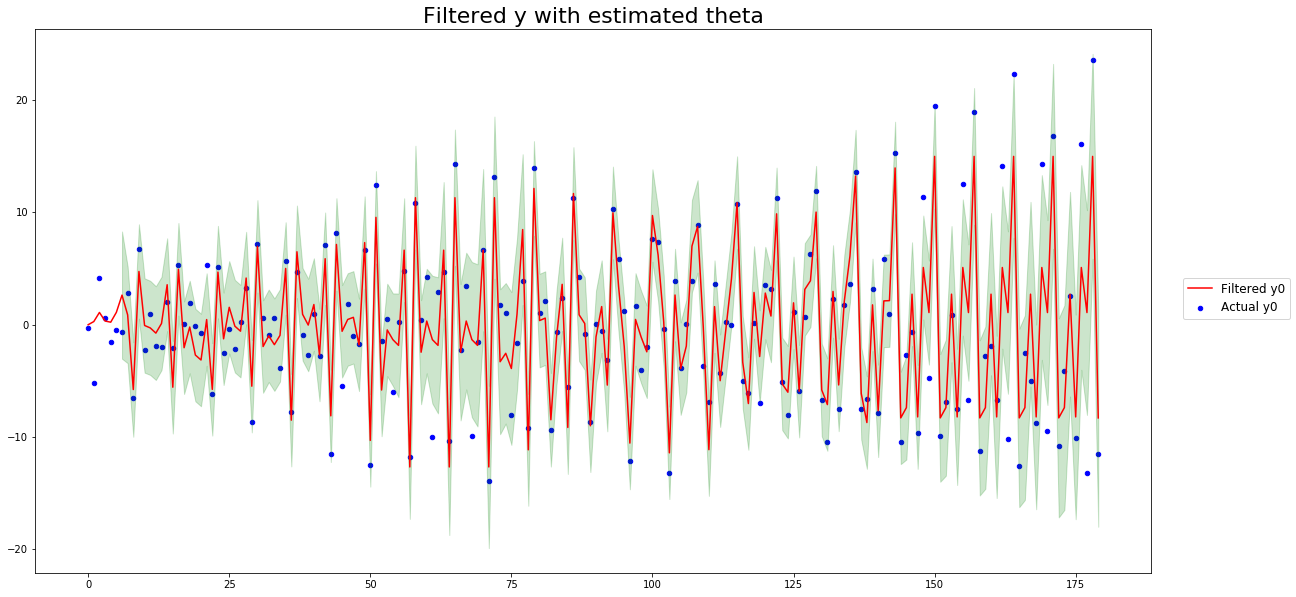

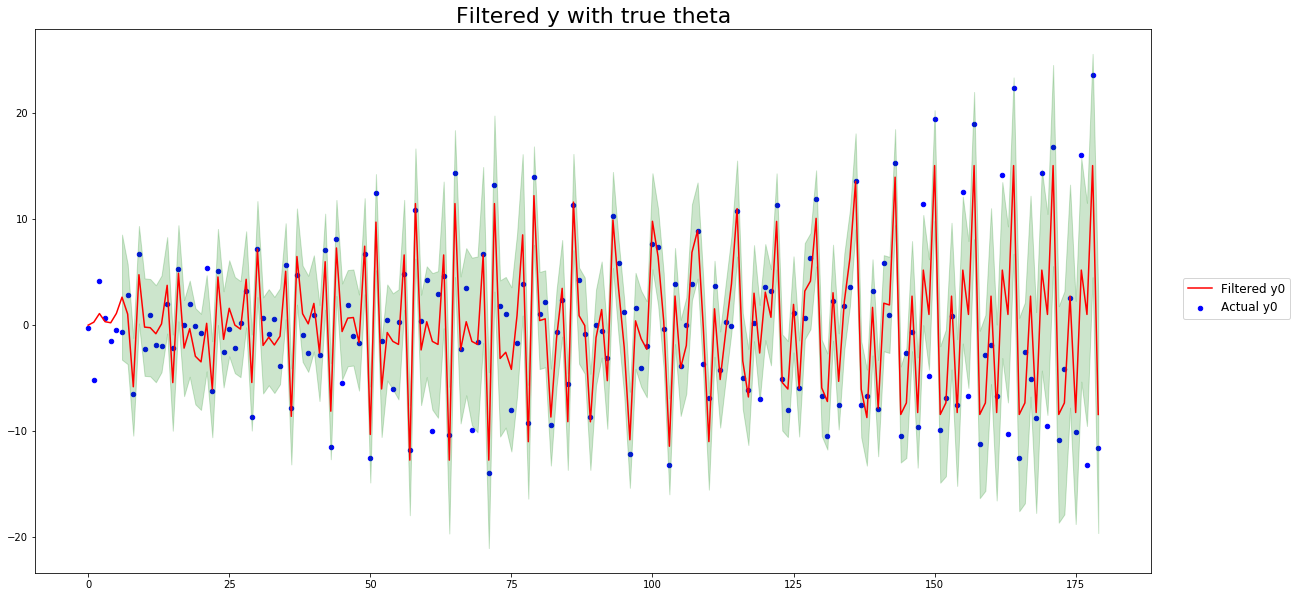

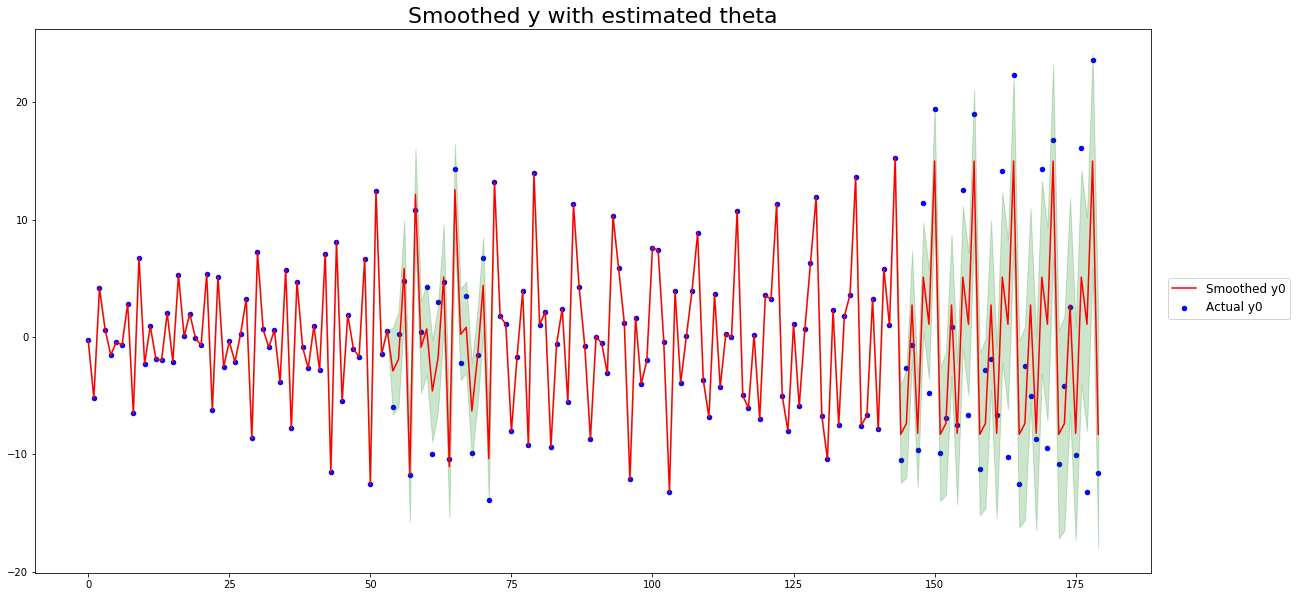

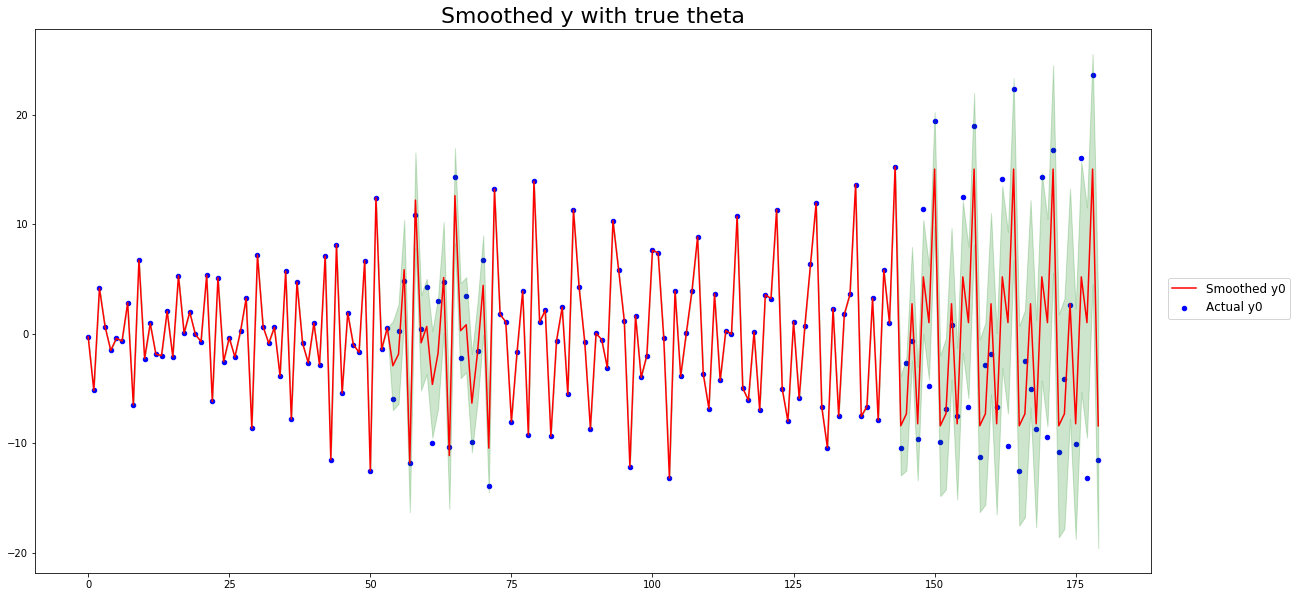

In [8]:
simple_plot(df_LLY, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with estimated theta')
simple_plot(df_true, 'y_0_filtered', 'y_0_vis', 'kf_ub', 'kf_lb', 'Filtered y0', 'Actual y0',
           'Filtered y with true theta')
simple_plot(df_LLY, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with estimated theta')
simple_plot(df_true, 'y_0_smoothed', 'y_0_vis', 'ks_ub', 'ks_lb', 'Smoothed y0', 'Actual y0',
           'Smoothed y with true theta')

In [9]:
# Build a simple function
def summary_stats(df, col_est, col_true):
    RMSE = np.sqrt((df[col_est] - df[col_true]).var())
    mean_error = (df[col_est] - df[col_true]).mean()
    return {'RMSE': RMSE, 'mean_error': mean_error}

In [10]:
# Compare model performance in training data
print('LLY theta for training data: {}'.format(
    summary_stats(df_LLY[is_train], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for training data: {}'.format(
    summary_stats(df_true[is_train], 'y_0_filtered', 'y_0_vis')))

LLY theta for training data: {'RMSE': 2.5518452499618727, 'mean_error': 0.03331731674141872}
Ture theta for training data: {'RMSE': 2.5352959670790436, 'mean_error': 0.03201280427935757}


In [11]:
# Compare model performance in test data
print('LLY theta for test data: {}'.format(
    summary_stats(df_LLY[is_test], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for test data: {}'.format(
    summary_stats(df_true[is_test], 'y_0_filtered', 'y_0_vis')))

LLY theta for test data: {'RMSE': 1.891496714391943, 'mean_error': 0.14691029380987533}
Ture theta for test data: {'RMSE': 1.8946804889636948, 'mean_error': 0.16931786250053674}


In [12]:
# Compare model performance in forecast data
print('LLY theta for forecast data: {}'.format(
    summary_stats(df_LLY[is_forecast], 'y_0_filtered', 'y_0_vis')))
print('Ture theta for forecast data: {}'.format(
    summary_stats(df_true[is_forecast], 'y_0_filtered', 'y_0_vis')))

LLY theta for forecast data: {'RMSE': 6.1441707388947595, 'mean_error': -0.03266398690936986}
Ture theta for forecast data: {'RMSE': 6.090958628817335, 'mean_error': -0.03587685296715485}
